# House Price Prediction Model
## Project Overview
This notebook develops a machine learning model to predict house prices based on various features.


## 1. Import Libraries


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Load and Explore Data


In [8]:
# Load dataset
df = pd.read_csv("../data/Housing.csv")
print("Dataset Shape:", df.shape)
# First 5 rows
df.head(5)


Dataset Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [9]:
print(df['furnishingstatus'].unique())

['furnished' 'semi-furnished' 'unfurnished']


In [10]:
# Basic information
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [11]:
# Statistical summary
print("\nStatistical Summary:")
df.describe()



Statistical Summary:


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [12]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [13]:
# Check data types and unique values for categorical columns
print("\nCategorical Columns:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}: {df[col].unique()}")



Categorical Columns:

mainroad: ['yes' 'no']

guestroom: ['no' 'yes']

basement: ['no' 'yes']

hotwaterheating: ['no' 'yes']

airconditioning: ['yes' 'no']

prefarea: ['yes' 'no']

furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


## 3. Data Preprocessing


In [14]:
# Create a copy for preprocessing
df_processed = df.copy()

# Label encode categorical variables
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include='object').columns

print("Encoding categorical variables:")
for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nProcessed data:")
df_processed.head()


Encoding categorical variables:
mainroad: {'no': np.int64(0), 'yes': np.int64(1)}
guestroom: {'no': np.int64(0), 'yes': np.int64(1)}
basement: {'no': np.int64(0), 'yes': np.int64(1)}
hotwaterheating: {'no': np.int64(0), 'yes': np.int64(1)}
airconditioning: {'no': np.int64(0), 'yes': np.int64(1)}
prefarea: {'no': np.int64(0), 'yes': np.int64(1)}
furnishingstatus: {'furnished': np.int64(0), 'semi-furnished': np.int64(1), 'unfurnished': np.int64(2)}

Processed data:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


## 4. Exploratory Data Analysis (EDA)


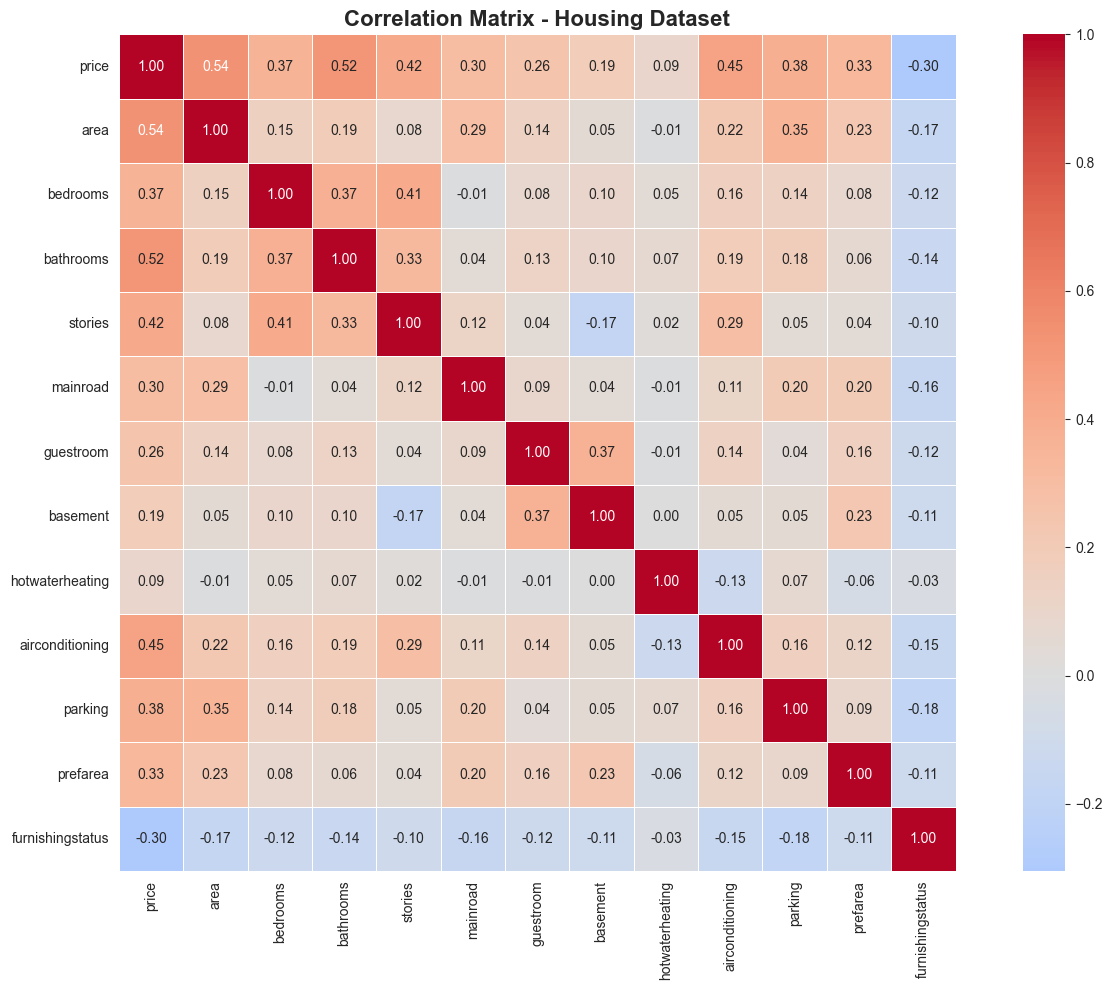

In [15]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df_processed.corr()
sns.heatmap(
    data=correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix - Housing Dataset", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [16]:
# Feature correlation with target
print("Features Correlation with Price (sorted):")
price_corr = df_processed.corr()['price'].sort_values(ascending=False)
print(price_corr)


Features Correlation with Price (sorted):
price               1.000000
area                0.535997
bathrooms           0.517545
airconditioning     0.452954
stories             0.420712
parking             0.384394
bedrooms            0.366494
prefarea            0.329777
mainroad            0.296898
guestroom           0.255517
basement            0.187057
hotwaterheating     0.093073
furnishingstatus   -0.304721
Name: price, dtype: float64


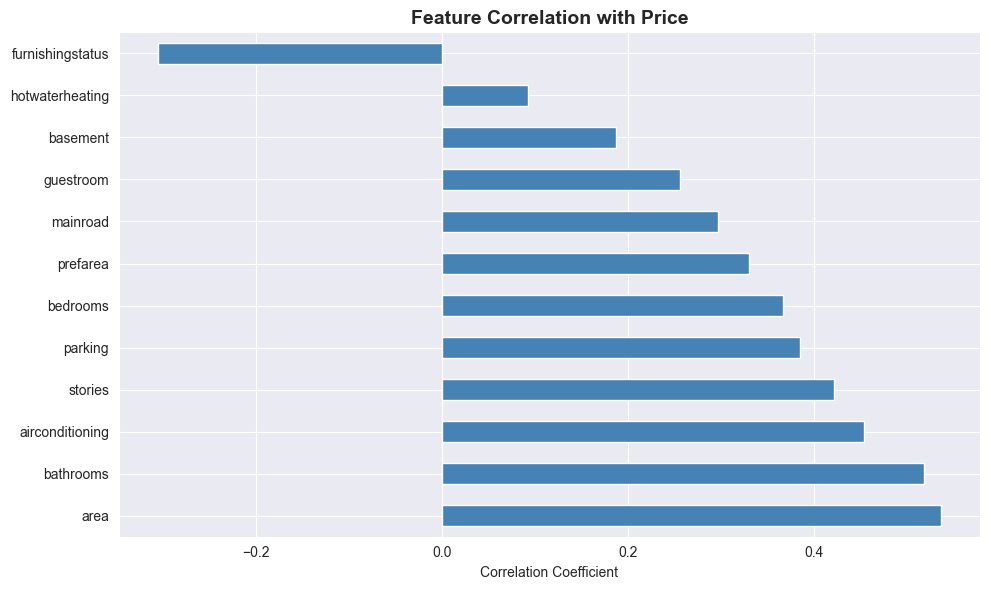

In [17]:
# Visualize top features correlation with price
plt.figure(figsize=(10, 6))
price_corr[1:].plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Price', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


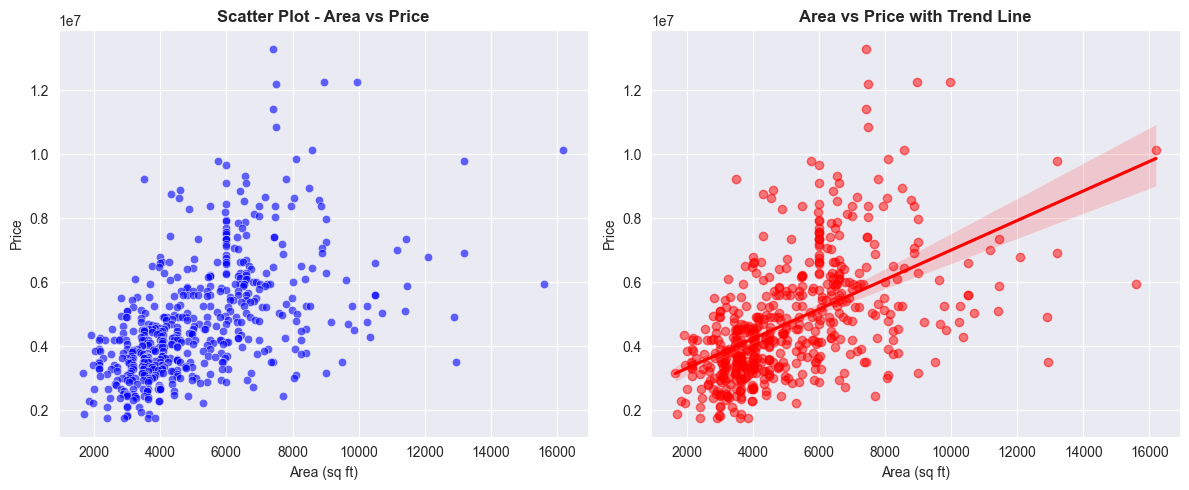

In [18]:
# Scatter plot: Area vs Price
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_processed, x='area', y='price', alpha=0.6, color='blue')
plt.title("Scatter Plot - Area vs Price", fontsize=12, fontweight='bold')
plt.xlabel('Area (sq ft)')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
sns.regplot(data=df_processed, x='area', y='price', scatter_kws={'alpha':0.5}, color='red')
plt.title('Area vs Price with Trend Line', fontsize=12, fontweight='bold')
plt.xlabel('Area (sq ft)')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


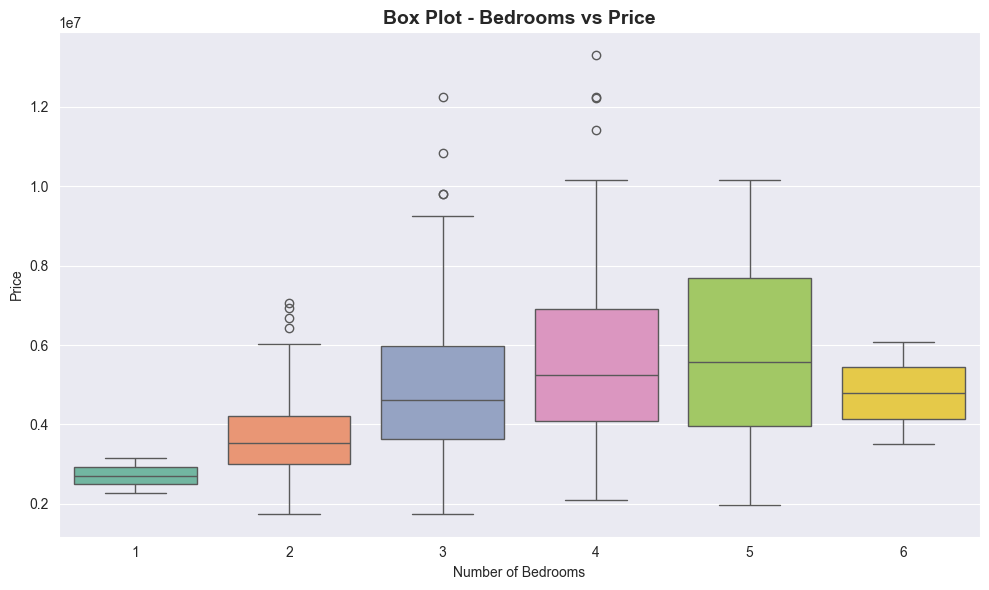

In [19]:
# Box plot: Bedrooms vs Price (checking outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_processed, x='bedrooms', y='price', palette='Set2')
plt.title("Box Plot - Bedrooms vs Price", fontsize=14, fontweight='bold')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


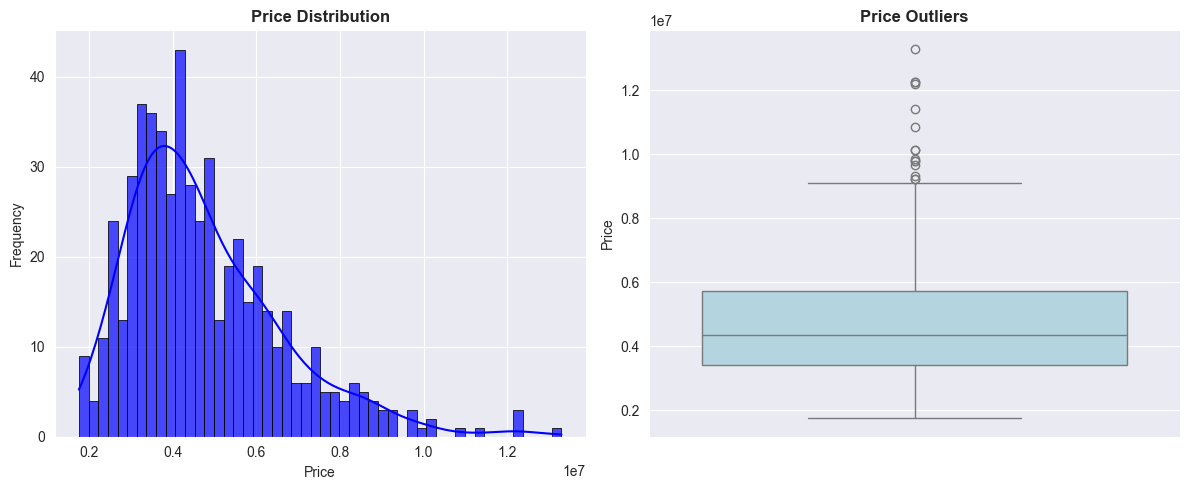

In [20]:
# Price distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_processed['price'], bins=50, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title("Price Distribution", fontsize=12, fontweight='bold')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_processed['price'], color='lightblue')
plt.title("Price Outliers", fontsize=12, fontweight='bold')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


## 5. Feature Engineering & Data Preparation


In [21]:
# Separate features and target
X = df_processed.drop('price', axis=1)
y = df_processed['price']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeatures:", X.columns.tolist())


Features shape: (545, 12)
Target shape: (545,)

Features: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 436
Test set size: 109


In [23]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed!")
print(f"Scaled training data shape: {X_train_scaled.shape}")


Scaling completed!
Scaled training data shape: (436, 12)


## 6. Model Training & Evaluation


### 6.1 Baseline Random Forest Model


In [24]:
# Train baseline Random Forest
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    min_samples_split=5,
    max_depth=15
)

rf_baseline.fit(X_train_scaled, y_train)
y_pred_rf_baseline = rf_baseline.predict(X_test_scaled)

# Evaluate
r2_rf_baseline = r2_score(y_test, y_pred_rf_baseline)
mae_rf_baseline = mean_absolute_error(y_test, y_pred_rf_baseline)
rmse_rf_baseline = np.sqrt(mean_squared_error(y_test, y_pred_rf_baseline))

print("=" * 50)
print("BASELINE RANDOM FOREST MODEL")
print("=" * 50)
print(f"R² Score: {r2_rf_baseline:.4f}")
print(f"MAE: {mae_rf_baseline:,.0f}")
print(f"RMSE: {rmse_rf_baseline:,.0f}")


BASELINE RANDOM FOREST MODEL
R² Score: 0.6095
MAE: 1,028,078
RMSE: 1,404,886



Feature Importance:
             feature  importance
0               area    0.479526
2          bathrooms    0.159185
8    airconditioning    0.064425
3            stories    0.053023
9            parking    0.052716
11  furnishingstatus    0.046489
1           bedrooms    0.044954
6           basement    0.029601
10          prefarea    0.029498
7    hotwaterheating    0.017029
5          guestroom    0.013947
4           mainroad    0.009607


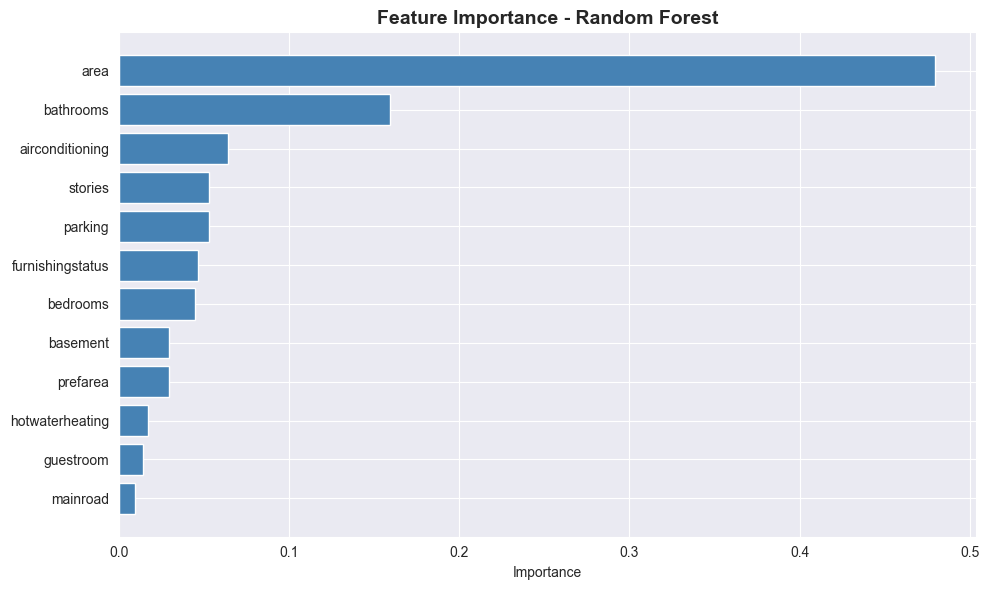

In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 6.2 Hyperparameter Tuning with GridSearchCV


In [26]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
print("Starting GridSearchCV... This may take a few minutes.")
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "=" * 50)
print("GRID SEARCH RESULTS")
print("=" * 50)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation R² Score: {grid_search.best_score_:.4f}")


Starting GridSearchCV... This may take a few minutes.
Fitting 5 folds for each of 108 candidates, totalling 540 fits

GRID SEARCH RESULTS
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation R² Score: 0.6207


In [27]:
# Evaluate tuned model
rf_tuned = grid_search.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)

r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))

print("\n" + "=" * 50)
print("TUNED RANDOM FOREST MODEL")
print("=" * 50)
print(f"R² Score: {r2_rf_tuned:.4f}")
print(f"MAE: {mae_rf_tuned:,.0f}")
print(f"RMSE: {rmse_rf_tuned:,.0f}")



TUNED RANDOM FOREST MODEL
R² Score: 0.5943
MAE: 1,054,675
RMSE: 1,432,037


### 6.3 Gradient Boosting Model


In [28]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print("=" * 50)
print("GRADIENT BOOSTING MODEL")
print("=" * 50)
print(f"R² Score: {r2_gb:.4f}")
print(f"MAE: {mae_gb:,.0f}")
print(f"RMSE: {rmse_gb:,.0f}")


GRADIENT BOOSTING MODEL
R² Score: 0.4719
MAE: 1,207,184
RMSE: 1,633,760


### 6.4 XGBoost Model


In [29]:
# Install XGBoost if not already installed
try:
    from xgboost import XGBRegressor
except ImportError:
    print("Installing XGBoost...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    from xgboost import XGBRegressor


In [30]:
# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("=" * 50)
print("XGBOOST MODEL")
print("=" * 50)
print(f"R² Score: {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:,.0f}")
print(f"RMSE: {rmse_xgb:,.0f}")


XGBOOST MODEL
R² Score: 0.5050
MAE: 1,153,567
RMSE: 1,581,811


## 7. Model Comparison


In [31]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (Tuned)',
        'Gradient Boosting',
        'XGBoost'
    ],
    'R² Score': [r2_rf_baseline, r2_rf_tuned, r2_gb, r2_xgb],
    'MAE': [mae_rf_baseline, mae_rf_tuned, mae_gb, mae_xgb],
    'RMSE': [rmse_rf_baseline, rmse_rf_tuned, rmse_gb, rmse_xgb]
})

results = results.sort_values('R² Score', ascending=False).reset_index(drop=True)
print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(results.to_string(index=False))



MODEL COMPARISON
                   Model  R² Score          MAE         RMSE
Random Forest (Baseline)  0.609521 1.028078e+06 1.404886e+06
   Random Forest (Tuned)  0.594282 1.054675e+06 1.432037e+06
                 XGBoost  0.504978 1.153567e+06 1.581811e+06
       Gradient Boosting  0.471929 1.207184e+06 1.633760e+06


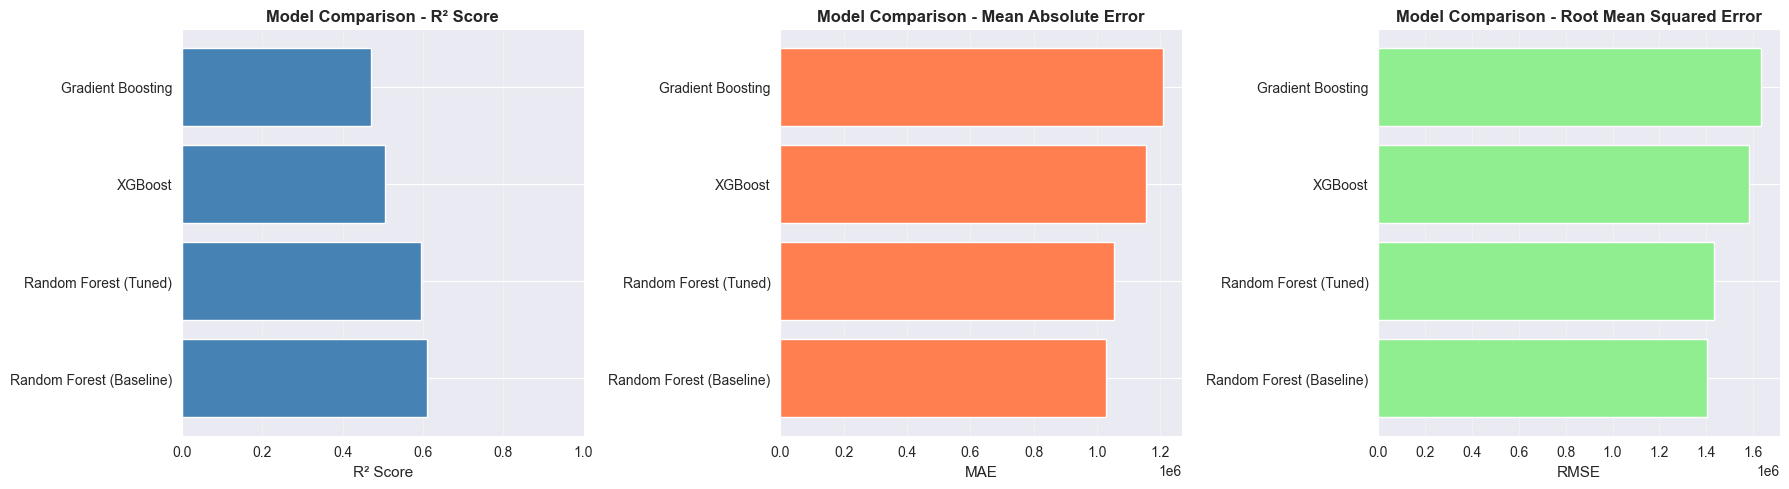

In [32]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score
axes[0].barh(results['Model'], results['R² Score'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=11)
axes[0].set_title('Model Comparison - R² Score', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# MAE
axes[1].barh(results['Model'], results['MAE'], color='coral')
axes[1].set_xlabel('MAE', fontsize=11)
axes[1].set_title('Model Comparison - Mean Absolute Error', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# RMSE
axes[2].barh(results['Model'], results['RMSE'], color='lightgreen')
axes[2].set_xlabel('RMSE', fontsize=11)
axes[2].set_title('Model Comparison - Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Prediction Visualization


In [33]:
# Select the best model
best_model_name = results.iloc[0]['Model']
print(f"Best Model: {best_model_name}")

# Get predictions from the best model
if 'Tuned' in best_model_name:
    best_model = rf_tuned
    best_predictions = y_pred_rf_tuned
elif 'XGBoost' in best_model_name:
    best_model = xgb_model
    best_predictions = y_pred_xgb
elif 'Gradient' in best_model_name:
    best_model = gb_model
    best_predictions = y_pred_gb
else:
    best_model = rf_baseline
    best_predictions = y_pred_rf_baseline


Best Model: Random Forest (Baseline)


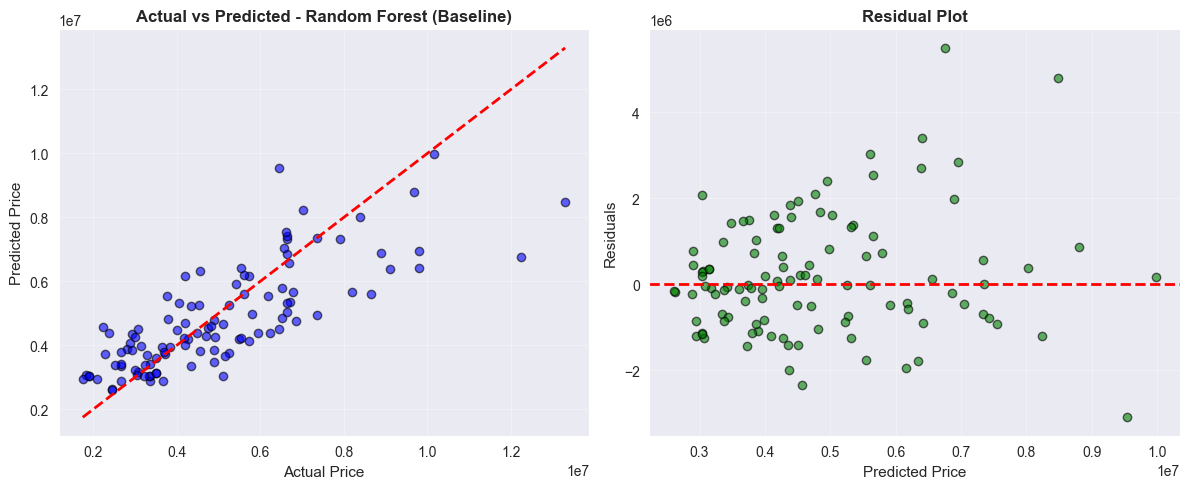

In [34]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6, color='blue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price', fontsize=11)
plt.ylabel('Predicted Price', fontsize=11)
plt.title(f'Actual vs Predicted - {best_model_name}', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6, color='green', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price', fontsize=11)
plt.ylabel('Residuals', fontsize=11)
plt.title('Residual Plot', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Test Prediction Function


In [35]:
def predict_house_price(features_dict):
    """
    Predict house price from features dictionary
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary containing all required features
    
    Returns:
    --------
    float : Predicted price
    """
    # Create the dataframe from input
    input_df = pd.DataFrame([features_dict])
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Predict
    prediction = best_model.predict(input_scaled)[0]
    
    return prediction


## 11. Summary & Conclusions


### Key Findings:
1. **Best Model Performance**:
   - Model: {best_model_name}
   - R² Score: {results.iloc[0]['R² Score']:.4f}
   - MAE: {results.iloc[0]['MAE']:,.0f}
   
2. **Most Important Features**:
   - Area is the strongest predictor of house price
   - Location factors (mainroad, prefarea) are significant
   - Amenities (bathrooms, parking) contribute to pricing

3. **Model Ready for Deployment**:
   - All artifacts saved in ml-model/ directory
   - Ready for Flask API integration
   - Includes preprocessing pipeline
